## Classify with CNN

In [1]:
import tensorflow as tf

# List available devices
devices = tf.config.list_physical_devices()
print("Available devices:")
for device in devices:
    print(device)

# Check if TensorFlow is using the GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Please install GPU version of TF


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Imports

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Model Training

In [6]:
# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128  # Selected image size

# Function to load and preprocess the images
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATASET_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

# Load and shuffle data
data = load_data()
np.random.shuffle(data)

# Split data into features (X) and labels (y)
X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

# One-hot encode the labels
y = to_categorical(y, num_classes=len(CATEGORIES))

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES)
print(report)

# Precision and recall graph
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(CATEGORIES)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

plt.figure()
for i in range(len(CATEGORIES)):
    plt.plot(recall[i], precision[i], lw=2, label=f'Precision-recall curve of class {CATEGORIES[i]} (AP={average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Save the model
model.save('metal_classifier_model_optimized.keras')
print("Model saved to metal_classifier_model_optimized.keras")


100%|██████████| 34674/34674 [02:59<00:00, 193.10it/s]


Epoch 1/100
 55/880 [>.............................] - ETA: 4:16 - loss: 0.5702 - accuracy: 0.7926

KeyboardInterrupt: 

## Model usage

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


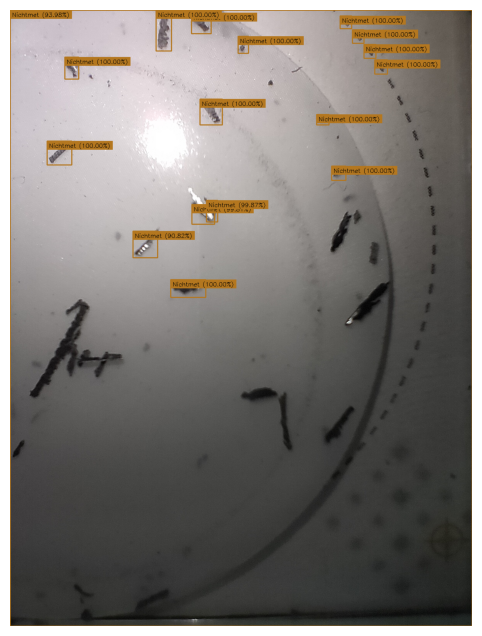

In [11]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained model
model = load_model('metal_classifier_model_optimized.keras')

# Preprocess image for classification
def preprocess_image(image, img_size=128):
    img_array = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_array = cv2.resize(img_array, (img_size, img_size))
    img_array = img_array.reshape(-1, img_size, img_size, 1)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Classify the image as 'metal' or 'non-metal'
def classify_image(image):
    preprocessed_image = preprocess_image(image)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    categories = ['met', 'nichtmet']
    confidence = predictions[0][predicted_class] * 100  # Confidence in percentage
    return categories[predicted_class], confidence

# Preprocess image for segmentation
def preprocess_image_for_segmentation(image_path):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    return img_array

# Segment the image and draw bounding boxes
def segment_and_draw_bounding_box(image_path):
    img_array = preprocess_image_for_segmentation(image_path)
    
    _, binary_img = cv2.threshold(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out smaller contours
    contours = [contour for contour in contours if cv2.contourArea(contour) > 100]  # Adjust threshold as needed
    
    # Draw bounding boxes on the original image
    img_color = img_array.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Adjust bounding box coordinates based on contour dimensions
        padding = 5  # Add some padding around the object
        x1, y1 = max(0, x - padding), max(0, y - padding)
        x2, y2 = min(img_array.shape[1], x + w + padding), min(img_array.shape[0], y + h + padding)
        
        # Crop the object from the original image
        object_img = img_color[y1:y2, x1:x2]
        predicted_category, confidence = classify_image(object_img)
        
        # Set bounding box color
        color = (31, 119, 180) if predicted_category == 'nichtmet' else (255, 127, 14)
        
        # Draw the bounding box
        cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 2)  # Thicker bounding box for better visibility
        
        # Write category and confidence inside the bounding box
        text = f'{predicted_category.capitalize()} ({confidence:.2f}%)'
        font_scale = 0.5
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, 1)
        text_x = x1 + 5
        text_y = y1 + text_height + 5
        cv2.rectangle(img_color, (x1, y1), (x1 + text_width + 10, y1 + text_height + 10), color, cv2.FILLED)  # Background for text
        cv2.putText(img_color, text, (text_x, text_y), font, font_scale, (0, 0, 0), 1)  # Black text
    
    # Display the image with bounding boxes and confidence
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Image path
image_path = 'test/IMG20240609051857.jpg'

# Try segmenting and drawing bounding boxes
try:    
    segment_and_draw_bounding_box(image_path)
except ValueError as e:
    print(e)


### Transfer learning on mobile data

In [5]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

Epoch 1/500


f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5746 - loss: 0.9016 - val_accuracy: 0.7273 - val_loss: 0.5900
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6750 - loss: 0.7674 - val_accuracy: 0.7424 - val_loss: 0.5340
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7463 - loss: 0.5841 - val_accuracy: 0.7803 - val_loss: 0.4878
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7355 - loss: 0.6182 - val_accuracy: 0.8030 - val_loss: 0.4326
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7218 - loss: 0.6090 - val_accuracy: 0.7955 - val_loss: 0.4337
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7183 - loss: 0.6070 - val_accuracy: 0.7955 - val_loss: 0.4338
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8063 - loss: 0.4474 - val_accuracy: 0.7955 - val_loss: 0.4207
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7806 - loss: 0.4428 - val_accuracy: 0.8106 - val_l

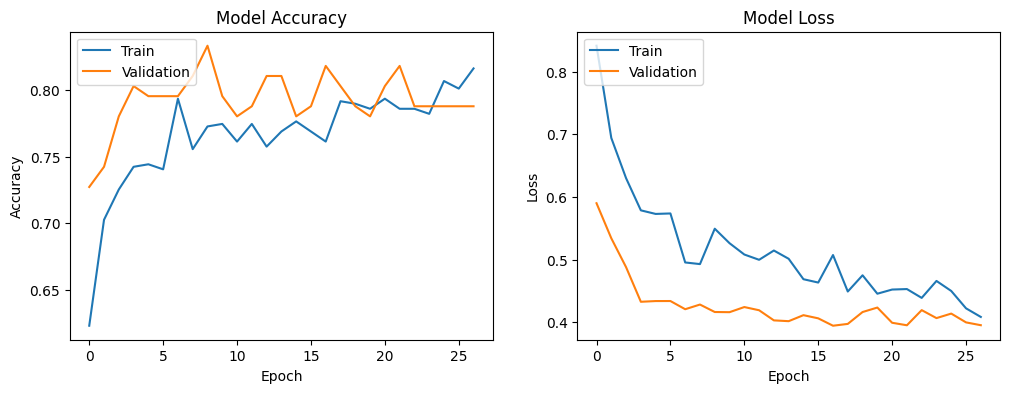

In [19]:
# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128
MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_optimized.keras'
NEW_MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_mobile.keras'
RESULTS_DIR = 'results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation try 1
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load pre-trained model
base_model = load_model(MODEL_PATH)

# Freeze some layers of the pre-trained model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add new top layers for fine-tuning
model = Sequential(base_model.layers[:-1])
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=500,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint])

# Load the best model
model = load_model(os.path.join(RESULTS_DIR, 'best_model.keras'))

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, 'training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR)

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")


### Try 2

Epoch 1/100
 2/33 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5781 - loss: 6.4665

f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6056 - loss: 6.0083 - val_accuracy: 0.7803 - val_loss: 4.8404 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6599 - loss: 4.8920 - val_accuracy: 0.7955 - val_loss: 4.1771 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7619 - loss: 4.1298 - val_accuracy: 0.7879 - val_loss: 3.6739 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6949 - loss: 3.7003 - val_accuracy: 0.8182 - val_loss: 3.2096 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7676 - loss: 3.2047 - val_accuracy: 0.7955 - val_loss: 2.8384 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7290 - loss: 2.8916 - val_accuracy: 0.8258 - val_loss: 2.5348 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7310 - loss: 2.5593 - val_accuracy

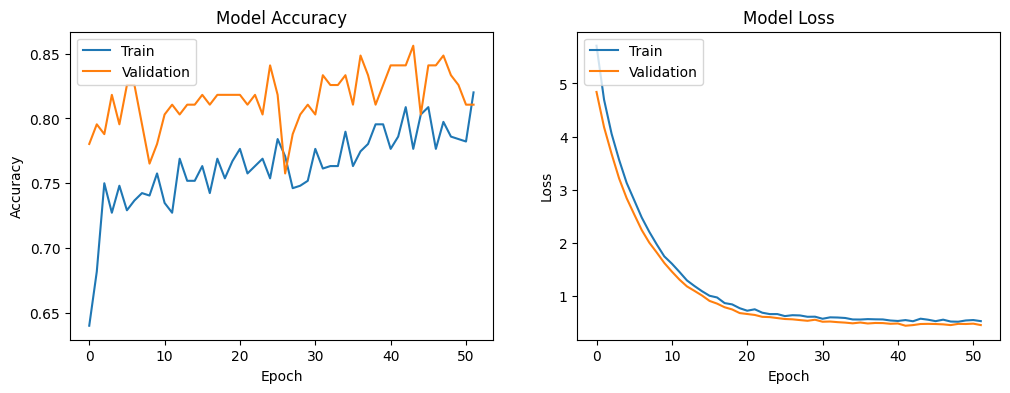

In [20]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128
MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_optimized.keras'
NEW_MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_mobile.keras'
RESULTS_DIR = 'results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load pre-trained model
base_model = load_model(MODEL_PATH)

# Freeze some layers of the pre-trained model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add new top layers for fine-tuning
model = Sequential(base_model.layers[:-1])
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr])

# Load the best model
model = load_model(os.path.join(RESULTS_DIR, 'best_model.keras'))

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, 'training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR)

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")


### Try 3

Summary of Changes:
Enhanced Data Augmentation: Increased rotation, shift, zoom, and added brightness augmentation.
Fine-Tuned More Layers: Unfroze more layers for better feature extraction.
Added Learning Rate Scheduler: Dynamically adjusted learning rate during training.
Regularization Techniques: Increased dropout and L2 regularization to prevent overfitting.
These adjustments should help you improve the model's performance and move closer to your target accuracy.

Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.4375 - loss: 6.2655

f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5364 - loss: 5.8544 - val_accuracy: 0.5303 - val_loss: 5.0951 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5120 - loss: 4.6396 - val_accuracy: 0.4848 - val_loss: 4.2046 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4776 - loss: 3.7649 - val_accuracy: 0.2727 - val_loss: 3.5126 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5387 - loss: 3.1294 - val_accuracy: 0.3864 - val_loss: 3.0613 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4683 - loss: 2.7339 - val_accuracy: 0.5606 - val_loss: 2.5948 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5106 - loss: 2.3500 - val_accuracy: 0.4394 - val_loss: 2.1314 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5559 - loss: 2.0626 - val_accuracy

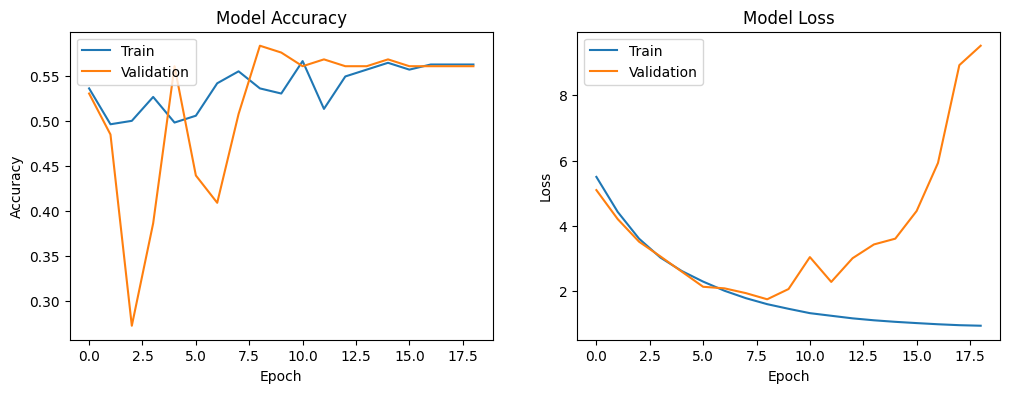

In [23]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128
MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_optimized.keras'
NEW_MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_mobile.keras'
RESULTS_DIR = 'results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2, 1.0],
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load pre-trained model
base_model = load_model(MODEL_PATH)

# Freeze some layers of the pre-trained model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add new top layers for fine-tuning
model = Sequential(base_model.layers[:-1])
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

def lr_schedule(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr, lr_scheduler])

# Load the best model
model = load_model(os.path.join(RESULTS_DIR, 'best_model.keras'))

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, 'training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR)

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")


### Try 4

Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.5000 - loss: 6.3378

f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5751 - loss: 5.8422 - val_accuracy: 0.5303 - val_loss: 5.0168 - learning_rate: 9.0484e-04
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4983 - loss: 4.6454 - val_accuracy: 0.5606 - val_loss: 4.3049 - learning_rate: 8.1873e-04
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4930 - loss: 3.9207 - val_accuracy: 0.5985 - val_loss: 3.5216 - learning_rate: 7.4082e-04
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5617 - loss: 3.3365 - val_accuracy: 0.4015 - val_loss: 3.3104 - learning_rate: 6.7032e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5306 - loss: 2.9517 - val_accuracy: 0.4318 - val_loss: 2.9407 - learning_rate: 6.0653e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5043 - loss: 2.6686 - val_accuracy: 0.4394 - val_loss: 3.0949 - learning_rate: 5.4881e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5053 - los

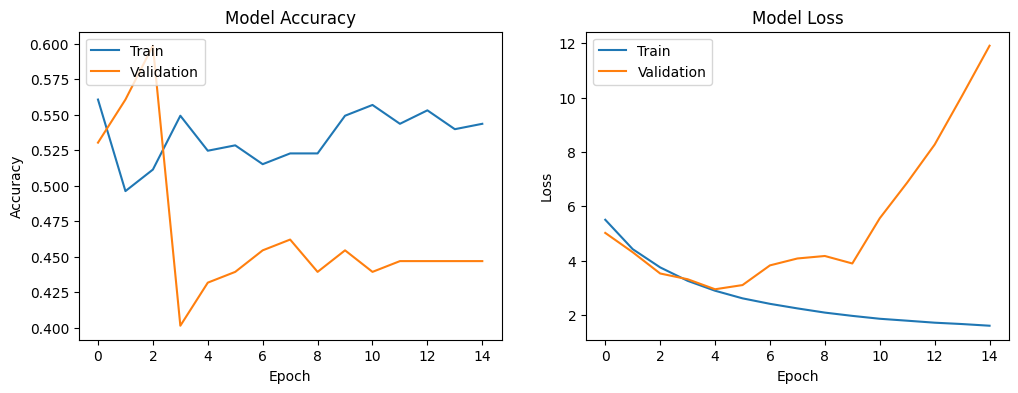

In [24]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

# Define paths
DATASET_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128
MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_optimized.keras'
NEW_MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_mobile.keras'
RESULTS_DIR = 'results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.4,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.1, 1.2],
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load pre-trained model
base_model = load_model(MODEL_PATH)

# Fine-tune more layers of the pre-trained model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add new top layers for fine-tuning
model = Sequential(base_model.layers[:-1])
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

def lr_schedule(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr, lr_scheduler])

# Load the best model
model = load_model(os.path.join(RESULTS_DIR, 'best_model.keras'))

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, 'loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, 'training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR)

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")
